In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from scipy.stats import wilcoxon

In [5]:
tempTopDir = '/Volumes/Britt_SSD/ReDoEvals3/UserStudy/'
filePath = os.path.join(tempTopDir, 'GP_Main.parquet')

filePath = os.path.join(tempTopDir, 'likertSlim_corrected.parquet')
likertSlim = pd.read_parquet(filePath)


likertSlim['visuals'] = np.where(likertSlim['visuals']=="Visuals","Charts",
                        np.where(likertSlim['visuals']=="Blur_Plus_Vis","Blur+Charts",likertSlim['visuals']))

likertSlim['ag_correctedPerc'] = likertSlim['1_2_correctedPerc']
likertSlim['Q17_Z'] = likertSlim['17.0_Z']
likertSlim['Q18_Z'] = likertSlim['18.0_Z']
likertSlim['Q19_Z'] = likertSlim['19.0_Z']
likertSlim['Q20_Z'] = likertSlim['20.0_Z']

tmp1 = likertSlim[['blurring_helpful_1_Z', \
      'blurring_helpful_2_Z', 'charts_helpful_1_Z', 'charts_helpful_2_Z', 'info_sufficient_1_Z', \
            'info_sufficient_2_Z', 'irrelevant_distracting_1_Z', 'irrelevant_distracting_2_Z', \
            'scenarios_helpful_1_Z', 'scenarios_helpful_2_Z','17.0_Z','18.0_Z','19.0_Z','20.0_Z']]
tmp1['likertMode_AndComp_Z'] = np.where(tmp1.mode(axis=1)[2].notnull(),tmp1.mode(axis=1)[1],tmp1.mode(axis=1)[0])
likertSlim['likertMode_AndComp_Z'] = tmp1['likertMode_AndComp_Z']

tmp1 = likertSlim[['blurring_helpful_1', \
      'blurring_helpful_2', 'charts_helpful_1', 'charts_helpful_2', 'info_sufficient_1', \
            'info_sufficient_2', 'irrelevant_distracting_1', 'irrelevant_distracting_2', \
            'scenarios_helpful_1', 'scenarios_helpful_2','17.0','18.0','19.0','20.0']]
tmp1['likertMode_AndComp'] = np.where(tmp1.mode(axis=1)[2].notnull(),tmp1.mode(axis=1)[1],tmp1.mode(axis=1)[0])
likertSlim['likertMode_AndComp'] = tmp1['likertMode_AndComp']

/Users/brittdavis/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/brittdavis/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
# drop particpants who have not been accepted (rejected or timed out)
pID_removed1 = likertSlim[(likertSlim['status']!='APPROVED')].ParticipantPublicID.unique()
print(len(likertSlim))
# drop these given row
# indexes from dataFrame
likertSlim = likertSlim[~likertSlim['ParticipantPublicID'].isin(pID_removed1)].copy()
print(len(likertSlim))
# tmp_slimDF = slimDF[~slimDF['ParticipantPublicID'].isin(pID_removed1)].copy()
# print(tmp_slimDF.status.unique())
# print(pID_removed1)
    
# tmp_demoDF_L = demoDF_L[~demoDF_L['ParticipantPublicID'].isin(pID_removed1)].copy()
# tmp_demoDF_S = demoDF_S[~demoDF_S['ParticipantPublicID'].isin(pID_removed1)].copy()

# tmp_consentDF_L = consentDF_L[~consentDF_L['ParticipantPublicID'].isin(pID_removed1)].copy()
# tmp_consentDF_S = consentDF_S[~consentDF_S['ParticipantPublicID'].isin(pID_removed1)].copy()

# tmp_aiDF_L = aiDF_L[~aiDF_L['ParticipantPublicID'].isin(pID_removed1)].copy()
# tmp_aiDF_S = aiDF_S[~aiDF_S['ParticipantPublicID'].isin(pID_removed1)].copy()

# tmp_taskDF = taskDF[~taskDF['ParticipantPublicID'].isin(pID_removed1)].copy()

# print(tmp_taskDF[tmp_taskDF['ParticipantPublicID']==pID_removed1[-3]])

232
232


In [7]:
df = likertSlim.copy()

for vis in df.visuals.unique():
    print(str(vis) + " " + str(len(df[df['visuals']==vis])))

Blur+Charts 54
Charts 58
Blurred 64
Video 56


In [8]:
vis = sorted(df['visuals'].unique())
print(vis)

['Blur+Charts', 'Blurred', 'Charts', 'Video']


In [9]:
# function to make statsmodel into dataframe
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    print(dir(results))
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [10]:
def negative_bold(val):
    bold = 'bold' if val < 0 else ''
    return 'font-weight: %s' % bold

In [59]:
df_ranked = likertSlim.copy()

df_ranked['tot1Perc_rank'] = df_ranked['Qs1_CorrectedPerc'].rank()
df_ranked['tot2Perc_rank'] = df_ranked['Qs2_CorrectedPerc'].rank()
df_ranked['agTotPerc_rank'] = df_ranked['1_2_correctedPerc'].rank()
df_ranked['compPerc_rank'] = df_ranked['comp_correctedPerc'].rank()
df_ranked['totPerc_rank'] = df_ranked['tot_correctedPerc'].rank()

In [11]:
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
# Part Three
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################
######################################################################################



In [38]:
# # Note that the three terms returned are X² statistic, p-value, and degree of freedom
def testChiCorr(a,b,c):
    ct = pd.crosstab(c[a], c[b], margins=True)
    ar = []
    for i in range(0, len(ct)-1):
        ar.append(list(ct.iloc[i][0:-1].values))
    obs = np.array(ar)
    X, p, degF = stats.chi2_contingency(obs)[0:3]
    if (p<=0.05):
        print("\n")
        print(str(a) + " " + str(stats.tmean(c[a])) + " " + str(stats.tstd(c[a])))
        print(str(b) + " " + str(stats.tmean(c[b])) + " " + str(stats.tstd(c[b])))
        print("p: ", p)
#     else:
#         print("\n"+ str(a) + " " + str(b))
    return(X, degF, p)

In [57]:
# Part Three:
df = df_ranked.copy()
# ORDINAL

# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()

# Chi-Square on likert1Mode v tot1Perc
a = 'likert1Mode'
b = 'tot1Perc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert1Mode v tot2Perc
# a = 'likert1Mode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v agTotPerc
# a = 'likert1Mode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v compPerc
# a = 'likert1Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v totPerc
# a = 'likert1Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))



# Chi-Square on likert2Mode v tot1Perc
# a = 'likert2Mode'
# b = 'tot1Perc'
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v tot2Perc
a = 'likert2Mode'
b = 'tot2Perc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert2Mode v agTotPerc
# a = 'likert2Mode'
# b = 'agTotPerc'

# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v compPerc
# a = 'likert2Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v totPerc
# a = 'likert2Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on likertMode v tot1Perc
# a = 'likertMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# # Chi-Square on likertMode v tot2Perc
# a = 'likertMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v agTotPerc
a = 'likertMode'
b = 'agTotPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likertMode v compPerc
# a = 'likertMode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v totPerc
# a = 'likertMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on CompResponseMode v tot1Perc
# a = 'CompResponseMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v tot2Perc
# a = 'CompResponseMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v agTotPerc
# a = 'CompResponseMode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v compPerc
a = 'CompResponseMode'
b = 'compPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on CompResponseMode v totPerc
# a = 'CompResponseMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




###############
# Chi-Square on likertMode_AndComp_Z v tot1Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v tot2Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v agTotPerc
# a = 'likertMode_AndComp_Z'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v compPerc
# a = 'likertMode_AndComp_Z'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v totPerc
a = 'likertMode_AndComp_Z'
b = 'totPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

likert1Mode tot1Perc_rank


KeyError: 'tot1Perc_rank'

In [70]:
df = df_ranked.copy()

for vis in df.visuals.unique():
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", vis)
    tmp = df[df['visuals']==vis].copy()
    
    print("Likerts p1")
    # Chi-Square on likert1Mode v tot1Perc
    a = 'likert1Mode_Z'
    b = 'tot1Perc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likert1Mode v tot2Perc
    # a = 'likert1Mode_Z'
    # b = 'Qs2_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likert1Mode v agTotPerc
    a = 'likert1Mode_Z'
    b = 'agTotPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likert1Mode v compPerc
    # a = 'likert1Mode_Z'
    # b = 'comp_correctedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likert1Mode v totPerc
    # a = 'likert1Mode_Z'
    # b = 'tot_correctedPerc'
    # print(testChiCorr(a,b,df))



    print("\nLikerts p2")
    # Chi-Square on likert2Mode v tot1Perc
    # a = 'likert2Mode_Z'
    # b = 'Qs1_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likert2Mode v tot2Perc
    a = 'likert2Mode_Z'
    b = 'tot2Perc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likert2Mode v agTotPerc
    a = 'likert2Mode_Z'
    b = 'agTotPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likert2Mode v compPerc
    # a = 'likert2Mode_Z'
    # b = 'comp_correctedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likert2Mode v totPerc
    # a = 'likert2Mode_Z'
    # b = 'tot_correctedPerc'
    # print(testChiCorr(a,b,df))



    print("\nLikerts p1+2")
    # Chi-Square on likertMode v tot1Perc
    # a = 'likertMode_Z'
    # b = 'Qs1_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode v tot2Perc
    # a = 'likertMode_Z'
    # b = 'Qs2_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode v agTotPerc
    a = 'likertMode_Z'
    b = 'agTotPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likertMode v compPerc
    # a = 'likertMode_Z'
    # b = 'comp_correctedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode v totPerc
    a = 'likertMode_Z'
    b = 'totPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))



    print("\nLikerts p3")
    # Chi-Square on CompResponseMode v tot1Perc
    # a = 'CompResponseMode_Z'
    # b = 'Qs1_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on CompResponseMode v tot2Perc
    # a = 'CompResponseMode_Z'
    # b = 'Qs2_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on CompResponseMode v agTotPerc
    # a = 'CompResponseMode_Z'
    # b = '1_2_correctedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on CompResponseMode v compPerc
    a = 'CompResponseMode_Z'
    b = 'compPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on CompResponseMode v totPerc
    a = 'CompResponseMode_Z'
    b = 'totPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))



    print("\nLikerts All")
    ###############
    # Chi-Square on likertMode_AndComp_Z v tot1Perc
    # a = 'likertMode_AndComp_Z'
    # b = 'Qs1_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode_AndComp_Z v tot2Perc
    # a = 'likertMode_AndComp_Z'
    # b = 'Qs2_CorrectedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode_AndComp_Z v agTotPerc
#     a = 'likertMode_AndComp_Z'
#     b = '1_2_correctedPerc'
#     testChiCorr(a,b,df)
#     s, p = stats.pearsonr(df[a],df[b])
#     if (p <= 0.05):
#         print(stats.pearsonr(df[a],df[b]))
#     pr, pr = stats.spearmanr(df[a],df[b])
#     if p <= 0.05:
#         print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likertMode_AndComp_Z v compPerc
    # a = 'likertMode_AndComp_Z'
    # b = 'comp_correctedPerc'
    # print(testChiCorr(a,b,df))

    # Chi-Square on likertMode_AndComp_Z v totPerc
    a = 'likertMode_AndComp_Z'
    b = 'totPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

    # Chi-Square on likertMode_AndComp_Z v totPerc
    a = 'likertMode_AndComp'
    b = 'totPerc_rank'
    testChiCorr(a,b,df)
    s, p = stats.pearsonr(df[a],df[b])
    if (p <= 0.05):
        print(stats.pearsonr(df[a],df[b]))
    pr, pr = stats.spearmanr(df[a],df[b])
    if p <= 0.05:
        print(stats.spearmanr(df[a],df[b]))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Blur+Charts
Likerts p1

Likerts p2

Likerts p1+2

Likerts p3
(0.20162087942948692, 0.0020275570513035765)
SpearmanrResult(correlation=0.19129011710571384, pvalue=0.0034449464160031507)

Likerts All
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Charts
Likerts p1

Likerts p2

Likerts p1+2

Likerts p3
(0.20162087942948692, 0.0020275570513035765)
SpearmanrResult(correlation=0.19129011710571384, pvalue=0.0034449464160031507)

Likerts All
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Blurred
Likerts p1

Likerts p2

Likerts p1+2

Likerts p3
(0.20162087942948692, 0.0020275570513035765)
SpearmanrResult(correlation=0.19129011710571384, pvalue=0.0034449464160031507)

Likerts All
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Video
Likerts p1

Likerts p2

Likerts p1+2

Likerts p3
(0.20162087942948692, 0.0020275570513035765)
SpearmanrResult(correlation=0.19129011710571384, pvalue=0.0034449464160031507)

Likerts All


In [15]:
# Part Three:

#a = 'comp_corrected'
# b = '1_2_correctedPerc'

# ORDINAL
df = likertSlim.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()

print("Likerts p1")
# Chi-Square on likert1Mode v tot1Perc
a = 'likert1Mode_Z'
b = 'Qs1_CorrectedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v tot2Perc
# a = 'likert1Mode_Z'
# b = 'Qs2_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likert1Mode v agTotPerc
a = 'likert1Mode_Z'
b = '1_2_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v compPerc
# a = 'likert1Mode_Z'
# b = 'comp_correctedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likert1Mode v totPerc
# a = 'likert1Mode_Z'
# b = 'tot_correctedPerc'
# print(testChiCorr(a,b,df))



print("\nLikerts p2")
# Chi-Square on likert2Mode v tot1Perc
# a = 'likert2Mode_Z'
# b = 'Qs1_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likert2Mode v tot2Perc
a = 'likert2Mode_Z'
b = 'Qs2_CorrectedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v agTotPerc
a = 'likert2Mode_Z'
b = '1_2_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v compPerc
# a = 'likert2Mode_Z'
# b = 'comp_correctedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likert2Mode v totPerc
# a = 'likert2Mode_Z'
# b = 'tot_correctedPerc'
# print(testChiCorr(a,b,df))



print("\nLikerts p1+2")
# Chi-Square on likertMode v tot1Perc
# a = 'likertMode_Z'
# b = 'Qs1_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode v tot2Perc
# a = 'likertMode_Z'
# b = 'Qs2_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode v agTotPerc
a = 'likertMode_Z'
b = '1_2_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v compPerc
# a = 'likertMode_Z'
# b = 'comp_correctedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode v totPerc
a = 'likertMode_Z'
b = 'tot_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))



print("\nLikerts p3")
# Chi-Square on CompResponseMode v tot1Perc
# a = 'CompResponseMode_Z'
# b = 'Qs1_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on CompResponseMode v tot2Perc
# a = 'CompResponseMode_Z'
# b = 'Qs2_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on CompResponseMode v agTotPerc
# a = 'CompResponseMode_Z'
# b = '1_2_correctedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on CompResponseMode v compPerc
a = 'CompResponseMode_Z'
b = 'comp_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v totPerc
a = 'CompResponseMode_Z'
b = 'tot_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))



print("\nLikerts All")
###############
# Chi-Square on likertMode_AndComp_Z v tot1Perc
# a = 'likertMode_AndComp_Z'
# b = 'Qs1_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode_AndComp_Z v tot2Perc
# a = 'likertMode_AndComp_Z'
# b = 'Qs2_CorrectedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode_AndComp_Z v agTotPerc
a = 'likertMode_AndComp_Z'
b = '1_2_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v compPerc
# a = 'likertMode_AndComp_Z'
# b = 'comp_correctedPerc'
# print(testChiCorr(a,b,df))

# Chi-Square on likertMode_AndComp_Z v totPerc
a = 'likertMode_AndComp_Z'
b = 'tot_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v totPerc
a = 'likertMode_AndComp'
b = 'tot_correctedPerc'
print(testChiCorr(a,b,df))
print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))

Likerts p1
(6133.112602058969, 0.45047471988358245, 6120)
(0.08339347588758467, 0.20567196894259532)
SpearmanrResult(correlation=0.049583472211379, pvalue=0.4522819340312477)
(16825.203343236284, 0.5089807249086846, 16830)
(0.07251871971529175, 0.2713081180517501)
SpearmanrResult(correlation=0.07638975185421998, pvalue=0.24647917040683745)

Likerts p2
(6229.160026844071, 0.5363017909806047, 6240)
(-0.00020277805986046058, 0.9975489497969539)
SpearmanrResult(correlation=-0.004787185496130108, pvalue=0.9421858558530745)
(17297.235103415103, 0.9473335035644326, 17600)
(-0.045506087519081584, 0.49035665164543457)
SpearmanrResult(correlation=-0.031956057835600994, pvalue=0.6282192236709216)

Likerts p1+2
(16245.12911680912, 0.9202319096679341, 16500)
(0.026763289503601535, 0.6850974517066343)
SpearmanrResult(correlation=0.03655964135889231, pvalue=0.5795532866808499)
(20238.883296703298, 0.2437090971838851, 20100)
(-0.005144243959020326, 0.9378820775508689)
SpearmanrResult(correlation=-0.00

/Users/brittdavis/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='likertMode_AndComp', ylabel='tot_correctedPerc'>

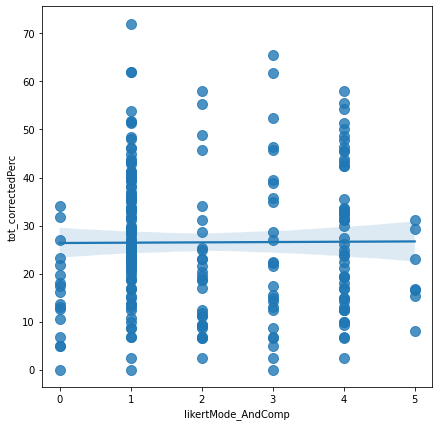

In [16]:
f, ax = plt.subplots(figsize=(7, 7))
# ax.set(xscale="log", yscale="log")
sns.regplot(a, b, df, ax=ax, scatter_kws={"s": 100})

<AxesSubplot:xlabel='comp_correctedPerc', ylabel='CompResponseMode_Z'>

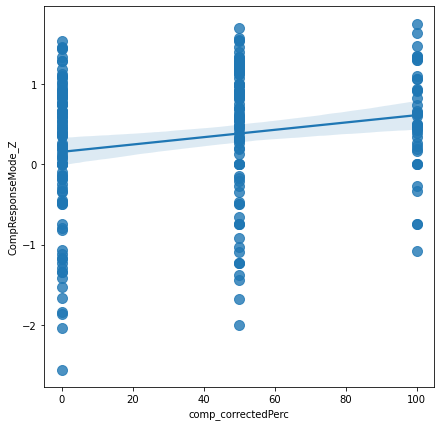

In [17]:

f, ax = plt.subplots(figsize=(7, 7))
# ax.set(xscale="log", yscale="log")
sns.regplot(y='CompResponseMode_Z', x='comp_correctedPerc', data=df, ax=ax, scatter_kws={"s": 100})

In [50]:
# Part Three:

# ORDINAL
df = df_ranked.copy()
df = df[df['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()

print("EASY")

# Chi-Square on likert1Mode v tot1Perc
a = 'likert1Mode'
b = 'tot1Perc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert1Mode v tot2Perc
# a = 'likert1Mode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v agTotPerc
# a = 'likert1Mode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v compPerc
# a = 'likert1Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v totPerc
# a = 'likert1Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))



# Chi-Square on likert2Mode v tot1Perc
# a = 'likert2Mode'
# b = 'tot1Perc'
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v tot2Perc
a = 'likert2Mode'
b = 'tot2Perc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert2Mode v agTotPerc
# a = 'likert2Mode'
# b = 'agTotPerc'

# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v compPerc
# a = 'likert2Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v totPerc
# a = 'likert2Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on likertMode v tot1Perc
# a = 'likertMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# # Chi-Square on likertMode v tot2Perc
# a = 'likertMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v agTotPerc
a = 'likertMode'
b = 'agTotPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likertMode v compPerc
# a = 'likertMode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v totPerc
# a = 'likertMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on CompResponseMode v tot1Perc
# a = 'CompResponseMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v tot2Perc
# a = 'CompResponseMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v agTotPerc
# a = 'CompResponseMode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v compPerc
a = 'CompResponseMode'
b = 'compPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on CompResponseMode v totPerc
# a = 'CompResponseMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




###############
# Chi-Square on likertMode_AndComp_Z v tot1Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v tot2Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v agTotPerc
# a = 'likertMode_AndComp_Z'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v compPerc
# a = 'likertMode_AndComp_Z'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v totPerc
a = 'likertMode_AndComp_Z'
b = 'totPerc_rank'
print(a, b)
print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

EASY
likert1Mode tot1Perc_rank
(100.45401620832655, 124, 0.9404840876235193)
SpearmanrResult(correlation=0.10258931951593285, pvalue=0.2862015686884244)
KendalltauResult(correlation=0.07959713951960455, pvalue=0.28794364014822793)
likert2Mode tot2Perc_rank
(107.67404490571157, 116, 0.6971517754136349)
SpearmanrResult(correlation=0.00012037913611737203, pvalue=0.9990041412273902)
KendalltauResult(correlation=-0.0002065194638665026, pvalue=0.997795261812348)
likertMode agTotPerc_rank
(263.61855640061776, 280, 0.751084400373008)
SpearmanrResult(correlation=0.15133784768118833, pvalue=0.11451567781621991)
KendalltauResult(correlation=0.11521755330636455, pvalue=0.11391906135662963)
CompResponseMode compPerc_rank
(10.472407407407408, 8, 0.23342089956535922)
SpearmanrResult(correlation=0.21498450763366414, pvalue=0.02410443882501907)
KendalltauResult(correlation=0.1883007419144606, pvalue=0.026407211194999752)
likertMode_AndComp_Z totPerc_rank
(6992.944444444446, 6970, 0.42083220454637343)
S

In [63]:
# Part Three:

# ORDINAL
df = df_ranked.copy()
print(len(df))
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
df = df[df['difficulty']=="Difficult"].copy()
print(len(df))
print("DIFFICULT")

# Chi-Square on likert1Mode v tot1Perc
a = 'likert1Mode'
b = 'tot1Perc_rank'
print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert1Mode v tot2Perc
# a = 'likert1Mode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v agTotPerc
# a = 'likert1Mode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v compPerc
# a = 'likert1Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert1Mode v totPerc
# a = 'likert1Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))



# Chi-Square on likert2Mode v tot1Perc
# a = 'likert2Mode'
# b = 'tot1Perc'
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v tot2Perc
a = 'likert2Mode'
b = 'tot2Perc_rank'
print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likert2Mode v agTotPerc
# a = 'likert2Mode'
# b = 'agTotPerc'

# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v compPerc
# a = 'likert2Mode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likert2Mode v totPerc
# a = 'likert2Mode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on likertMode v tot1Perc
# a = 'likertMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# # Chi-Square on likertMode v tot2Perc
# a = 'likertMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v agTotPerc
a = 'likertMode'
b = 'agTotPerc_rank'
print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on likertMode v compPerc
# a = 'likertMode'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode v totPerc
# a = 'likertMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




# Chi-Square on CompResponseMode v tot1Perc
# a = 'CompResponseMode'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v tot2Perc
# a = 'CompResponseMode'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v agTotPerc
# a = 'CompResponseMode'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on CompResponseMode v compPerc
a = 'CompResponseMode'
b = 'compPerc_rank'
print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

# Chi-Square on CompResponseMode v totPerc
# a = 'CompResponseMode'
# b = 'totPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))




###############
# Chi-Square on likertMode_AndComp_Z v tot1Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot1Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v tot2Perc
# a = 'likertMode_AndComp_Z'
# b = 'tot2Perc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v agTotPerc
# a = 'likertMode_AndComp_Z'
# b = 'agTotPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v compPerc
# a = 'likertMode_AndComp_Z'
# b = 'compPerc'
# print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
# print(stats.spearmanr(df[a],df[b]))

# Chi-Square on likertMode_AndComp_Z v totPerc
a = 'likertMode_AndComp_Z'
b = 'totPerc_rank'
print(a, b)
# print(testChiCorr(a,b,df))
# print(stats.pearsonr(df[a],df[b]))
print(stats.spearmanr(df[a],df[b]))
print(stats.kendalltau(df[a],df[b]))

232
122
DIFFICULT
likert1Mode tot1Perc_rank
SpearmanrResult(correlation=0.19275687524008164, pvalue=0.03340825687855493)
KendalltauResult(correlation=0.14251436854478686, pvalue=0.041647692767094485)
likert2Mode tot2Perc_rank
SpearmanrResult(correlation=0.1718996397754326, pvalue=0.05832252377533338)
KendalltauResult(correlation=0.12700885094550118, pvalue=0.06850417638334848)
likertMode agTotPerc_rank
SpearmanrResult(correlation=0.11477653827883122, pvalue=0.2080800974237887)
KendalltauResult(correlation=0.08375131375490734, pvalue=0.22053293487195447)
CompResponseMode compPerc_rank
SpearmanrResult(correlation=0.17695957198353185, pvalue=0.05119063769226058)
KendalltauResult(correlation=0.1565254329560492, pvalue=0.052799270316399)
likertMode_AndComp_Z totPerc_rank
SpearmanrResult(correlation=0.05087701754051214, pvalue=0.5778481913729836)
KendalltauResult(correlation=0.03595359575444747, pvalue=0.5603402616618853)


In [20]:
#blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
# info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
# Q17_Response+Q18_Response+Q19_Response+Q20_Response

a = 'tot1Perc'
b = 'blurring_helpful_1_Z'
print(testChiCorr(a,b,df))

a = 'tot2Perc'
b = 'blurring_helpful_2_Z'
print(testChiCorr(a,b,df))

a = 'tot1Perc'
b = 'charts_helpful_1_Z'
print(testChiCorr(a,b,df))

a = 'tot2Perc'
b = 'charts_helpful_2_Z'
print(testChiCorr(a,b,df))

a = 'tot1Perc'
b = 'info_sufficient_1_Z'
print(testChiCorr(a,b,df))

a = 'tot2Perc'
b = 'info_sufficient_2_Z'
print(testChiCorr(a,b,df))

a = 'compPerc'
b = '17.0_Z'
print(testChiCorr(a,b,df))

a = 'compPerc'
b = '18.0_Z'
print(testChiCorr(a,b,df))

a = 'compPerc'
b = '19.0_Z'
print(testChiCorr(a,b,df))

a = 'compPerc'
b = '20.0_Z'
print(testChiCorr(a,b,df))

(271.22539682539684, 0.7117411776738135, 285)
(309.1428571428571, 0.21024957883152512, 290)
(399.9802884615384, 0.05787755295113559, 357)
(312.4381316539211, 0.38768850867138865, 306)
(708.9724566638249, 0.3987508481901295, 700)
(628.6861020684296, 0.20202032633632358, 600)
(409.0383803521408, 0.18180616202895192, 384)
(428.1952240896359, 0.15919168057076657, 400)
(408.5556162464986, 0.18625127070049838, 384)
(428.3712184873949, 0.2342733287171982, 408)


In [21]:
# Part Three:

# Logistic
pVal = 0.01
rAdj = 0.05

df = likertSlim.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()
df['visuals']=pd.Categorical(df['visuals'])

# Logistic Regression on likert1Mode v tot1Perc
f_rev1 = 'tot1Perc ~ likert1Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v tot2Perc
f_rev1 = 'tot2Perc ~ likert1Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v agTotPerc
f_rev1 = 'agTotPerc ~ likert1Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v compPerc
f_rev1 = 'compPerc ~ likert1Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v totPerc
f_rev1 = 'totPerc ~ likert1Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())




# Logistic Regression on likert2Mode v tot1Perc
f_rev1 = 'tot1Perc ~ likert2Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert2Mode v tot2Perc
f_rev1 = 'tot2Perc ~ likert2Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert2Mode v agTotPerc
f_rev1 = 'agTotPerc ~ likert2Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert2Mode v compPerc
f_rev1 = 'compPerc ~ likert2Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert2Mode v totPerc
f_rev1 = 'totPerc ~ likert2Mode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())




# Logistic Regression on likertMode v tot1Perc
f_rev1 = 'tot1Perc ~ likertMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likertMode v tot2Perc
f_rev1 = 'tot2Perc ~ likertMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likertMode v agTotPerc
f_rev1 = 'agTotPerc ~ likertMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likertMode v compPerc
f_rev1 = 'compPerc ~ likertMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likertMode v totPerc
f_rev1 = 'totPerc ~ likertMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())





# Logistic Regression on CompResponseMode v tot1Perc
f_rev1 = 'tot1Perc ~ CompResponseMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on CompResponseMode v tot2Perc
f_rev1 = 'tot2Perc ~ CompResponseMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on CompResponseMode v agTotPerc
f_rev1 = 'agTotPerc ~ CompResponseMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on CompResponseMode v compPerc
f_rev1 = 'compPerc ~ CompResponseMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on CompResponseMode v totPerc
f_rev1 = 'totPerc ~ CompResponseMode_Z'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())



In [22]:
# Part Three:

# Logistic

df = likertSlim.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()
df['visuals']=pd.Categorical(df['visuals'])

# Logistic Regression on likert1Mode v tot1Perc
f_rev1 = 'tot1Perc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v tot2Perc
f_rev1 = 'tot2Perc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v agTotPerc
f_rev1 = 'agTotPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v compPerc
f_rev1 = 'compPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v totPerc
f_rev1 = 'totPerc ~ info_sufficient_1+info_sufficient_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())



Summary: 
                             OLS Regression Results                            
Dep. Variable:               compPerc   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     4.388
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           0.000126
Time:                        18:21:03   Log-Likelihood:                -222.99
No. Observations:                  54   AIC:                             476.0
Df Residuals:                      39   BIC:                             505.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              

In [23]:
# Part Three:

# Logistic

df = likertSlim.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()
df['visuals']=pd.Categorical(df['visuals'])

# Logistic Regression on likert1Mode v tot1Perc
f_rev1 = 'Qs1_CorrectedPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v tot2Perc
f_rev1 = 'Qs2_CorrectedPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v agTotPerc
f_rev1 = 'ag_correctedPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2+Q17_Response+Q18_Response+Q19_Response+Q20_Response+\
+likertMode+CompResponseMode+likert1Mode+likert2Mode'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v compPerc
f_rev1 = 'comp_correctedPerc ~ blurring_helpful_1_Z+blurring_helpful_2_Z+charts_helpful_1_Z+charts_helpful_2_Z+\
info_sufficient_1_Z+info_sufficient_2_Z+scenarios_helpful_1_Z'
# Q17_Z + Q18_Z + Q19_Z + Q20_Z'
# likertMode_Z+CompResponseMode_Z+likert1Mode_Z
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())

# Logistic Regression on likert1Mode v totPerc
f_rev1 = 'tot_correctedPerc ~ info_sufficient_1+info_sufficient_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < 0.05 and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())



Summary: 
                             OLS Regression Results                            
Dep. Variable:     comp_correctedPerc   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     3.766
Date:                Sun, 10 Apr 2022   Prob (F-statistic):            0.00263
Time:                        18:21:03   Log-Likelihood:                -258.63
No. Observations:                  54   AIC:                             533.3
Df Residuals:                      46   BIC:                             549.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept          

In [24]:
print(likertSlim.columns.tolist())

['ParticipantPrivateID', 'difficulty', 'visuals', 'agents', 'QsTotal', 'QsCorrect', 'Agent_QsTotal', 'Agent_QsCorrect', 'Agent_QsWO_GhostsTotal', 'Agent_QsWO_GhostsCorrect', 'Qs1_Correct', 'Qs2_Correct', 'QsPart_Total', 'predictionsCorrect', 'predictionsTotal', 'predictions1Correct', 'predictions2Correct', 'predictionsHalfTotal', 'regionsCorrect', 'regionsTotal', 'regions1Correct', 'regions2Correct', 'regionsHalfTotal', 'levelCorrect', 'levelTotal', 'level1Correct', 'level2Correct', 'levelHalfTotal', 'ghostsCorrect', 'ghostsTotal', 'ghosts1Correct', 'ghosts2Correct', 'ghostsHalfTotal', 'comparisonsCorrect', 'comparisonsTotal', 'timeTakenMain_All', 'timeTakenMain_AgentsOnly', 'timeTaken_Consent', 'timeTaken_Demographics', 'timeTaken_AI', 'timeTaken_Agent1', 'timeTaken_Agent2', 'timeTaken_Agent3', 'time_TOTAL', 'vidPlayed', 'avgVidPlays', 'ratioVidPlaysToAvg', 'ExperimentVersion_x', 'totPerc', 'agTotPerc', 'tot1Perc', 'tot2Perc', 'Agent_QsWO_GhostsPerc', 'predPerc', 'pred1Perc', 'pred2Pe

In [67]:
# Part Three:
rAdj = 0.05
pVal = 0.01
# Logistic

df = df_ranked.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()
df['visuals']=pd.Categorical(df['visuals'])

# Logistic Regression on likert1Mode v tot1Perc
f_rev1 = 'tot1Perc_rank ~ blurring_helpful_1+charts_helpful_1+ \
info_sufficient_1+scenarios_helpful_1'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v tot2Perc
f_rev1 = 'tot2Perc_rank ~ blurring_helpful_2+charts_helpful_2+ \
info_sufficient_2+scenarios_helpful_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v agTotPerc
f_rev1 = 'agTotPerc_rank ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v compPerc
f_rev1 = 'compPerc_rank ~ Q17_Response+Q18_Response+Q19_Response+Q20_Response'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v totPerc
f_rev1 = 'totPerc_rank ~ CompResponseMode+likert1Mode+likert2Mode'
# +irrelevant_distracting_1+irrelevant_distracting_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

pVal: 0.26306661400827447 r^2: 0.026121188376373894
pVal: 0.07966040241967304 r^2: 0.08474251476219585
pVal: 0.4280535752712033 r^2: 0.004516159888315441
pVal: 0.008480041957350583 r^2: 0.041538980860549746
Summary: 
                             OLS Regression Results                            
Dep. Variable:           totPerc_rank   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     5.286
Date:                Sun, 10 Apr 2022   Prob (F-statistic):            0.00153
Time:                        19:02:46   Log-Likelihood:                -1296.8
No. Observations:                 232   AIC:                             2602.
Df Residuals:                     228   BIC:                             2615.
Df Model:                           3                                         
Covariance Type:            nonrobust                                  

In [26]:
# Part Three:
rAdj = 0.05
pVal = 0.01
# Logistic

df = likertSlim.copy()
# df = likertSlim[likertSlim['difficulty']=="Easy"].copy()
# df = likertSlim[likertSlim['difficulty']=="Difficult"].copy()
df['visuals']=pd.Categorical(df['visuals'])

# Logistic Regression on likert1Mode v tot1Perc
f_rev1 = 'Qs1_CorrectedPerc ~ blurring_helpful_1+charts_helpful_1+ \
info_sufficient_1+scenarios_helpful_1'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v tot2Perc
f_rev1 = 'Qs2_CorrectedPerc ~ blurring_helpful_2+charts_helpful_2+ \
info_sufficient_2+scenarios_helpful_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v agTotPerc
f_rev1 = 'ag_correctedPerc ~ blurring_helpful_1+blurring_helpful_2+charts_helpful_1+charts_helpful_2+\
info_sufficient_1+info_sufficient_2+scenarios_helpful_1+\
scenarios_helpful_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v compPerc
f_rev1 = 'comp_correctedPerc ~ Q17_Response+Q18_Response+Q19_Response+Q20_Response'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))

# Logistic Regression on likert1Mode v totPerc
f_rev1 = 'tot_correctedPerc~ CompResponseMode+likert1Mode+likert2Mode'
# +irrelevant_distracting_1+irrelevant_distracting_2'
est = smf.ols(formula=f_rev1, data=df).fit()
if est.f_pvalue < pVal and est.rsquared_adj > rAdj:
    print('Summary: \n', est.summary())
else:
    print("pVal: " + str(est.f_pvalue) + " r^2: " + str(est.rsquared_adj))
    

    
#  = 'CompResponseMode_Z'
# b = 'Qs1_Corrected'
# print(testChiCorr(a,b,df))

# # Chi-Square on CompResponseMode v tot2Perc
# a = 'CompResponseMode_Z'
# b = 'Qs2_Corrected'
# print(testChiCorr(a,b,df))

# # Chi-Square on CompResponseMode v agTotPerc
# a = 'CompResponseMode_Z'
# b = '1_2_correctedPerc'
# print(testChiCorr(a,b,df))

# # Chi-Square on CompResponseMode v compPerc
# a = 'CompResponseMode_Z'
# b = 'comp_corrected'
# print(testChiCorr(a,b,df))

# # Chi-Square on CompResponseMode v totPerc
# a = 'CompResponseMode_Z'
# b = 'tot_correctedPerc'

pVal: 0.3159810656196975 r^2: 0.01606039250499447
pVal: 0.06493147285514708 r^2: 0.09392905297561116
pVal: 0.4715269681672203 r^2: -0.004603051051065066
pVal: 0.009792908848378275 r^2: 0.04014826062940924
pVal: 0.003086368958938051 r^2: 0.0465160013822149


In [27]:
print(len(likertSlim.irrelevant_distracting_1.unique()))
print(likertSlim.irrelevant_distracting_1.unique())

6
[nan  2.  5.  3.  4.  1.]


In [28]:
print('Summary: \n', est.summary())

Summary: 
                             OLS Regression Results                            
Dep. Variable:      tot_correctedPerc   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.756
Date:                Sun, 10 Apr 2022   Prob (F-statistic):            0.00309
Time:                        18:21:03   Log-Likelihood:                -944.71
No. Observations:                 232   AIC:                             1897.
Df Residuals:                     228   BIC:                             1911.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.6828  

In [29]:
df = likertSlim.copy()

In [30]:
testChiCorr('vidPlayed','tot_correctedPerc',df)



vidPlayed 77.58620689655173 45.11410621401554
tot_correctedPerc 26.497998768472904 14.667262169676476
p:  0.0014997747427062714


(13891.05589569161, 0.0014997747427062714, 13400)

In [31]:
print(df.columns.tolist())

['ParticipantPrivateID', 'difficulty', 'visuals', 'agents', 'QsTotal', 'QsCorrect', 'Agent_QsTotal', 'Agent_QsCorrect', 'Agent_QsWO_GhostsTotal', 'Agent_QsWO_GhostsCorrect', 'Qs1_Correct', 'Qs2_Correct', 'QsPart_Total', 'predictionsCorrect', 'predictionsTotal', 'predictions1Correct', 'predictions2Correct', 'predictionsHalfTotal', 'regionsCorrect', 'regionsTotal', 'regions1Correct', 'regions2Correct', 'regionsHalfTotal', 'levelCorrect', 'levelTotal', 'level1Correct', 'level2Correct', 'levelHalfTotal', 'ghostsCorrect', 'ghostsTotal', 'ghosts1Correct', 'ghosts2Correct', 'ghostsHalfTotal', 'comparisonsCorrect', 'comparisonsTotal', 'timeTakenMain_All', 'timeTakenMain_AgentsOnly', 'timeTaken_Consent', 'timeTaken_Demographics', 'timeTaken_AI', 'timeTaken_Agent1', 'timeTaken_Agent2', 'timeTaken_Agent3', 'time_TOTAL', 'vidPlayed', 'avgVidPlays', 'ratioVidPlaysToAvg', 'ExperimentVersion_x', 'totPerc', 'agTotPerc', 'tot1Perc', 'tot2Perc', 'Agent_QsWO_GhostsPerc', 'predPerc', 'pred1Perc', 'pred2Pe